#Reconstruction of palaeotopography from low-temperature thermochronological data

This notebook compares the quasi-analytic solution for isotherm perturbation, given by Wang Wei* and Zhou Zuyi: "Reconstruction of palaeotopography from low-temperature thermochronological data"

##quasi-analytic model

Because heat conduction in solids can be approximated as a linear physical process, the total perturbation of the thermal field caused by the topography can be adequately approximated by the sum of the perturbations caused by each of the components of the Fourier series. The perturbation caused by a periodic topography with small amplitude has been shown to be proportional to the amplitude of the topography, and to decay exponentially with depth (Turcotte et al. 1982). The steady-state solution for topography of constant geometry can therefore be expressed as



$$T(x,y) = T_0(y) + \sum_{n=0}^{N} \left[ 
   a_{n}\,\cos \left(\frac{2n\pi x}{\lambda} \right) \\
   + b_{n} \,\sin \left(\frac{2n\pi x}{\lambda}\right) \right] e^{ym_n} \left(\frac{\partial T_0(y)}{\partial y_{y=0}} - \phi\right)$$
   
Where

$$m_n = \frac{1}{2} \left(-u/k - \sqrt{(u/k)^2 + (4n \pi/\lambda)^2}  \right)$$

$\lambda$ is the width of the domain

$\lambda/n$ is the wavelength of the perturbation

$u$ is exhumation rate

$k$ is thermal diffusivity

$\phi$ is the lampse rate

$T_0(y)$ describes the geotherm with erosion at a steady rate, in the absence of any surface perturbations, and can be fixed according to the temperature at the surface and at the lower boundary of a slab

$$T_0(y) = T_s + \beta\left[1-\exp\left(-\frac{y}{h}\right) \right] + \gamma\left[1-\exp\left(-\frac{u}{\kappa}y\right) \right]$$

Which in the absence of heat-production ,reduces to:

$$T_0(y) = T_s + \gamma\left[1-\exp\left(-\frac{u}{\kappa}\right) \right]$$

$$\gamma = \frac{(T_L-T_s) - \beta \left[ 1-\exp\left( - \frac{L}{h}\right)\right]}{1-\exp \left(-\frac{u}{k} L\right)}$$

Which in the absence of heat-production ,reduces to:

$$\gamma = \frac{(T_L-T_s)}{1- \exp \left(-\frac{u}{k} L\right)}$$

For a box with surface temperature $T_s$ and constant temperature $T_L$ at depth $L$.

$h$ is the depth at which the heat production drops to
$1/e$ of the surface value $A_s$  (we don't need these paramters for no heat production).


In [1]:
import math
import numpy as np
import matplotlib.pylab as pyplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
##Key Parameters (similar to ....Wei & Zuyi)

#basal temp
TS = 0.
TL = 2500.

#depth of the box, amplitude, wavelength
W = 101.
L = 101.
#amp = 1.
wavelength = 30.
#exhumation / denudation  (0- 0.5 km / Ma)
u = 0.5
lapse = -4.5 #C/km
DTDY = 25.

#thermal diffusivity km^2 Ma-1 conversion used is 1m^2 s-2 = (365*24*3600)km^2 Ma-1
kappa = 1e-6*(365*24*3600)
kappa

31.535999999999998

##Scipy fft 


###Refresher course

Analysis:

$$X_k = \sum_{n=0}^{N-1} x[n] e^{-j 2\pi \frac{k n}{N}}$$

Each X_k is a complex number that encodes both amplitude and phase of a sinusoidal component of function x_n. The sinusoid's frequency is k cycles per N samples.  Its amplitude and phase are:

$$|X_k|/N = \sqrt{\operatorname{Re}(X_k)^2 + \operatorname{Im}(X_k)^2}/N$$

$$\arg(X_k) = \operatorname{atan2}\big( \operatorname{Im}(X_k), \operatorname{Re}(X_k) \big)=-i\operatorname{ln}\left(\frac{X_k}{|X_k|}\right)$$

From Euler's theorem...

$$e^{jx} = cos(x) + j sin(x)$$

$$X_k = \sum_{n=0}^{N-1} x[n] \left( cos(2\pi \frac{k n}{N}) - j sin(2\pi \frac{k n}{N}) \right) $$

Synthesis:

$$x[n] = \frac{1}{N} \sum_{n=0}^{N-1} X[k] e^{j2 \pi \frac{k n}{N}}$$

$$x[n] = \frac{1}{N} \sum_{n=0}^{N-1} X[k] \left( cos(2\pi \frac{k n}{N}) + j sin(2\pi \frac{k n}{N}) \right) $$

Note that the $X[k]$ coefficients are complex. We can assume that the $x[n]$ values
are real (

If $x_0, \ldots, x_{N-1}$ are real numbers, as they often are in practical applications, then the DFT obeys the symmetry:

$X_{N-k} \equiv X_{-k} = X_k^*$,  where $X^*\,$ denotes complex conjugation. It follows that $X_0$ and $X_{N/2}$ are real-valued, and the remainder of the DFT is completely specified by just $N/2-1$ complex numbers. Using this symmetry, http://www.robots.ox.ac.uk/~sjrob/Teaching/SP/l7.pdf shows that:

$$ x_k[n] = \frac{2}{N} \left( Re\{X[n]\} \cos \frac{2\pi}{N} nk - Im\{X[n]\} \sin \frac{2\pi}{N} nk \right) $$

$$ x[n] = \sum_{k=0}^{N-1} \frac{2}{N} \left( Re\{X[n]\} \cos \frac{2\pi}{N} nk - Im\{X[n]\} \sin \frac{2\pi}{N} nk \right) $$


###Scipy docs

Hence, for a signal $x[k]$ __scipy.fft__, returns:


$[y(0),y(1),..,y(n/2),y(1-n/2),...,y(-1)] $       if n is even

$[y(0),y(1),..,y((n-1)/2),y(-(n-1)/2),...,y(-1)]$  if n is odd

$y_j = \sum_{k=0}^{n-1} x[k] \exp(-2\pi \frac{j k}{n})$, j = 0..n-1


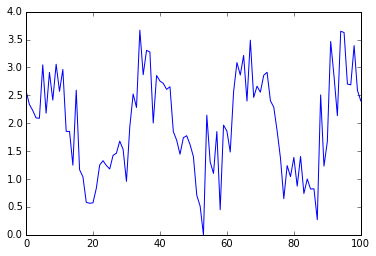

In [3]:
topolist = []
amp = 1.
xlist = np.arange(0, W, 1)
#xlist = np.array(horizontals)


topo = amp*(np.sin(2. * np.pi * xlist/(wavelength))) + 0.5 * np.random.randn(xlist.size)
topo += abs(topo.min())


pyplot.plot(xlist,topo)

In [4]:
from scipy import fftpack
sample_freq = fftpack.fftfreq(topo.size, d=1)
sig_fft = fftpack.fft(topo)

#trunc = 50.
yinv = fftpack.ifft(sig_fft)


In [5]:
#I had to drop a factor of two to get this to work: (2./N) => 1./N

def synth(ffcs):
    x = []
    N = len(ffcs)
    #print a0
    for k in range(len(ffcs)):
        xk = [(1./N)*((np.real(ffcs[k])*np.cos((2.*np.pi*n*k)/(N))) - np.imag(ffcs[k])*np.sin((2.*np.pi*n*k)/(N))) for n in range(N)]
        #xk.append(v)   
        x.append(xk)
    arr = np.array(x)
    return np.sum(arr, axis = 0.)

In [6]:
toposynth = synth(sig_fft)

/Users/dansandiford/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


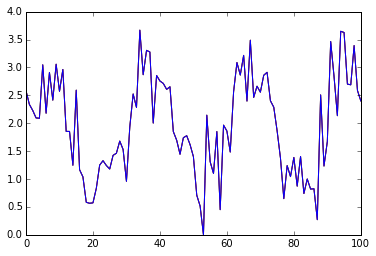

In [7]:
pyplot.plot(xlist, topo, color="green")
pyplot.plot(xlist, yinv, color="red")
pyplot.plot(xlist, toposynth)

In [8]:
def T0(y, TL, TS, L, u, kappa):
    gam = (TL-TS)/(1-np.exp(-L*(u/kappa)))
    t = TS + gam*(1-np.exp(-1*(u/kappa)*y))
    return t

In [9]:
T0(5, TL, TS, L, u, kappa)

238.65256051077557

In [10]:
def analytic_geotherm(y, ffcs, TL, TS, L, u, kappa,dtdy,lapse):
    #######
    #Get T0
    #######
    gam = (TL-TS)/(1-np.exp(-L*(u/kappa)))
    T0 = TS + gam*(1-np.exp(-1*(u/kappa)*y))
    #######
    #Compute pertubation from Fourier coeffcients
    #######
    t = []
    N = len(ffcs)
    for k in range(len(ffcs)):
        mk = 0.5*((-1*u)/(kappa)) - 0.5*((np.sqrt((u/kappa)**2) + ((4*k*np.pi)/(N))**2))
        xk = [(1./N)*((np.real(ffcs[k])*np.cos((2.*np.pi*n*k)/(N))) - np.imag(ffcs[k])*np.sin((2.*np.pi*n*k)/(N))) for n in range(N)]
        expterm = np.exp(mk*y)*(dtdy - lapse)
        temppert = [i*expterm for i in xk]
        #print mk
        t.append(temppert)
    arr = np.array(t)
    tp = np.sum(arr, axis = 0.)
    tp += T0
    return tp


In [11]:
analytic_geotherm(30, sig_fft, TL, TS, L, u, kappa, DTDY, lapse)

array([ 1224.20458752,  1224.17172995,  1224.09266218,  1223.96879492,
        1223.80250968,  1223.59710128,  1223.35670657,  1223.08621994,
        1222.79119603,  1222.47773937,  1222.15238114,  1221.82194314,
        1221.49338976,  1221.17366939,  1220.86954786,  1220.58743714,
        1220.3332238 ,  1220.11210237,  1219.92841967,  1219.78553615,
        1219.68571066,  1219.63001452,  1219.61828009,  1219.6490879 ,
        1219.71979513,  1219.8266065 ,  1219.9646868 ,  1220.12831258,
        1220.31105865,  1220.50601326,  1220.70601461,  1220.90389979,
        1221.09275695,  1221.2661707 ,  1221.41845085,  1221.54483528,
        1221.64165842,  1221.70647804,  1221.73815502,  1221.73688204,
        1221.70415995,  1221.64272205,  1221.55640908,  1221.44999977,
        1221.32900358,  1221.19942395,  1221.06750177,  1220.93944972,
        1220.82118833,  1220.71809512,  1220.63477718,  1220.57487722,
        1220.54092118,  1220.5342144 ,  1220.55479078,  1220.60141752,
      

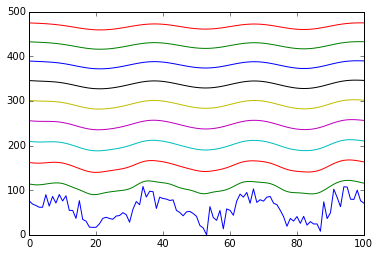

In [13]:
##I don't think this will handle "negative" topography, which is why I normalised the synthetic profile

depthtemps = [analytic_geotherm(depth, sig_fft, TL, TS, L, u, kappa, DTDY, lapse) for depth in np.arange(0.0,10.,1)]
for depth in depthtemps:
    pyplot.plot(xlist, depth)
#test

In [50]:
topo.shape

(101,)

In [69]:
#dim = 31.*101
a = np.zeros((31,101))


In [71]:
for y in range(a.shape[0]):
    T = analytic_geotherm(y, sig_fft, TL, TS, L, u, kappa, DTDY, lapse)
    a[y,:] = T
        


In [81]:
plt.contourf?

In [86]:
a[20,0]/120

7.4824899557207605

<matplotlib.colorbar.Colorbar instance at 0x10c263998>

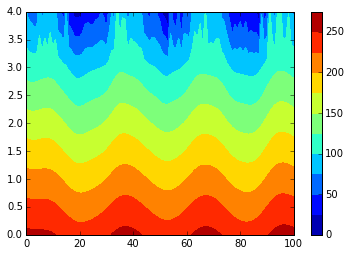

In [103]:
plt.contourf(flipud(a[0:5,:]), 10) 
plt.colorbar()

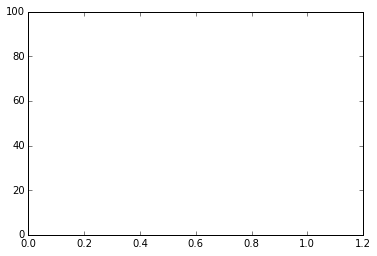

In [100]:
import matplotlib.pyplot as plt
import matplotlib._cntr as cntr
import scipy
level=100
X,Y = scipy.meshgrid(scipy.arange(a.shape[0]),scipy.arange(a.shape[1]))
c = cntr.Cntr(X, Y, a.T)
nlist = c.trace(level, level, 0)
segs = nlist[:len(nlist)//2]
for seg in segs:
    plt.plot(seg[:,0],seg[:,1],color='white')
plt.show()

##Underworld model

In [13]:
# Stagnant lid convection model

%matplotlib inline

import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import matplotlib.pylab as pyplot
import numpy as np

In [14]:
W

101.0

In [15]:
dim = 2
meshX = 100
meshY = 100
maxX = W
maxY = L


Q1dP0Mesh = uw.mesh.FeMesh_Cartesian( elementType=("linear", "constant"),
                                      elementRes=(meshX,meshY), 
                                      minCoord=(0.,0.), maxCoord=(maxX,maxY)  )

Q1Mesh =  Q1dP0Mesh # returns outer mesh by default


velocityMesh =  Q1Mesh


xCoordFn = fn.input()[0]
yCoordFn = fn.input()[1]

In [16]:
coordinate = fn.input()

In [17]:
##Dimensionless quantities
#maxX = 51.
#maxY = 35.

##Dimensionless quantities

#def Z(X,eps, x, y):
#    return X + eps*rho(x,y)


In [18]:
dim = 2

# create & zero fevariables
velocityField    = uw.fevariable.FeVariable( feMesh=velocityMesh,   nodeDofCount=dim )
temperatureField = uw.fevariable.FeVariable( feMesh=velocityMesh,   nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
temperatureField.data[:] = 0.

#Initial Temperature and BCs


In [19]:
toptemp = TS
deltemp = TL

In [20]:
#toptemp

In [21]:
for index, coord in enumerate(velocityMesh.data):
    #temperatureField.data[index] = TL
    temperatureField.data[index] = T0((maxY - coord[1]), TL, TS, L, u, kappa)

In [22]:

IWalls = velocityMesh.specialSets["MinI_VertexSet"] + velocityMesh.specialSets["MaxI_VertexSet"]
JWalls = velocityMesh.specialSets["MinJ_VertexSet"] + velocityMesh.specialSets["MaxJ_VertexSet"]
# also set dirichlet for temp field
tempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              nodeIndexSets=(JWalls,) )

In [23]:
 toptemp + deltemp

2500.0

In [24]:
# lets ensure temp boundaries are still what we want as the IC above might have set slightly different values
# on the boundaries
for index in velocityMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = toptemp + deltemp
for index in velocityMesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = toptemp

In [25]:
topbound = velocityMesh.specialSets["MaxJ_VertexSet"]
bottombound = velocityMesh.specialSets["MinJ_VertexSet"]
heights = coordinate.evaluate(topbound)[:,1]
horizontals = coordinate.evaluate(topbound)[:,0]

In [26]:
len(topo)

101

In [27]:
#meshfig = plt.Figure(figsize=(1500, 500))
#meshfig.Mesh(velocityMesh, colourBar=False)
#meshfig.show()

In [28]:
#maxX

In [29]:
#wavelengths = [30.]
#topolist = []
#amp = 1.
#xlist = list(horizontals)

#def sin_pert(x,amp,lam):
#    return amp*math.sin(2.*math.pi*(maxX/lam)*x)
    
    


#for i in range(len(wavelengths)):   
#    topo = [sin_pert(j,amp,wavelengths[i]) for j in xlist]
#    topolist.append(topo)
#out = np.array(topolist)
    

In [30]:
#topo = out.mean(axis=0)
#topo[:] = topo[:] - out.

In [31]:
#pyplot.plot(horizontals,topo)

In [32]:
velocityMesh.specialSets.keys()

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

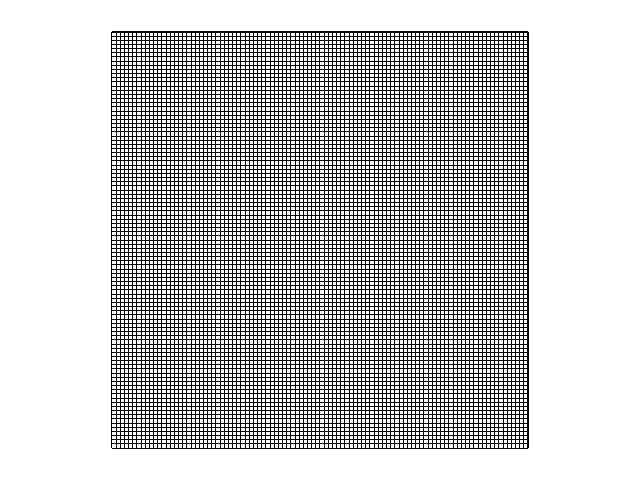

In [33]:
meshfig = plt.Figure()
meshfig.Mesh(velocityMesh, colourBar=False)
meshfig.show()

In [34]:
from scipy import interpolate
f = interpolate.interp1d(horizontals, topo)

In [35]:
for index, coord in enumerate(velocityMesh.data):
    y0 = coord[1]
    pert = f(coord[0])
    velocityMesh.data[index][1] = y0 + ((y0/maxY)*pert)
    

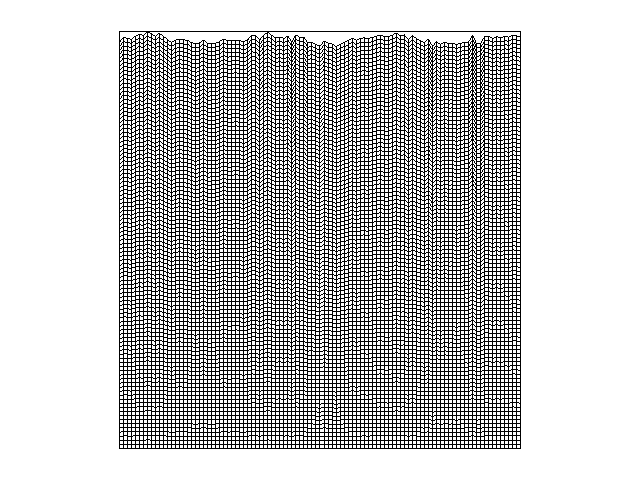

In [36]:
meshfig = plt.Figure()
meshfig.Mesh(velocityMesh, colourBar=False)
meshfig.show()

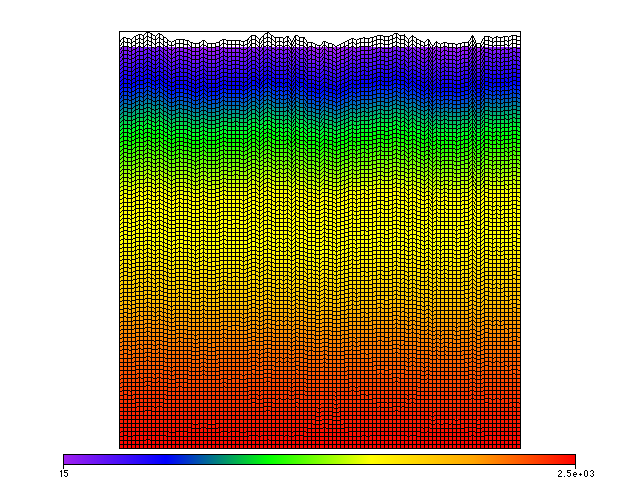

In [37]:
figtemp = plt.Figure()
figtemp.Surface(temperatureField, velocityMesh)
figtemp.Mesh(velocityMesh, colourBar=False)
figtemp.show()

In [38]:
meshtopography = coordinate.evaluate(topbound)[:,1]
bottom = coordinate.evaluate(bottombound)[:,1]

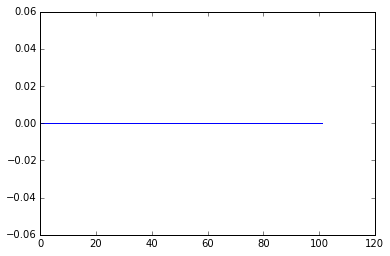

In [39]:
#Check interpolation and bottom boundary (should be zero)
pyplot.plot(horizontals,meshtopography - (topo+maxY), color = 'g')
pyplot.plot(horizontals,bottom, color = 'b')

In [40]:
xps = np.linspace(0, 101, 101)
len(xps)

101

In [41]:
T0(-1, TL, TS, L, u, kappa)

-50.043077476895867

In [42]:
maxY

101.0

In [43]:
#Set proper temperatures

#for index, coord in enumerate(velocityMesh.data):
#    if coord[1] >= maxY:
#        temperatureField.data[index] = toptemp + 1
#    else:
#        temperatureField.data[index] = T0((maxY - coord[1]), TL, TS, L, u, kappa)

##Set up isosurface swarm

In [44]:
xps = np.linspace(0, 101, 101)
yps = np.ones(101)*90.

isoswarm = uw.swarm.Swarm( feMesh=velocityMesh )
isoswarm.add_particles_with_coordinates(np.array((xps,yps)).T)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int32)

##Setup advection - diffusion


In [45]:
print(u)

0.5


In [46]:
velocityField.data[:] = [0,u]

In [47]:
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=kappa, conditions=[tempBC,] )

In [48]:
print "timestep in years: " + str(advDiff.get_max_dt()*1e6)

timestep in years: 505000.0


In [49]:
advDiff.get_max_dt()

0.5049999999999955

##Solve

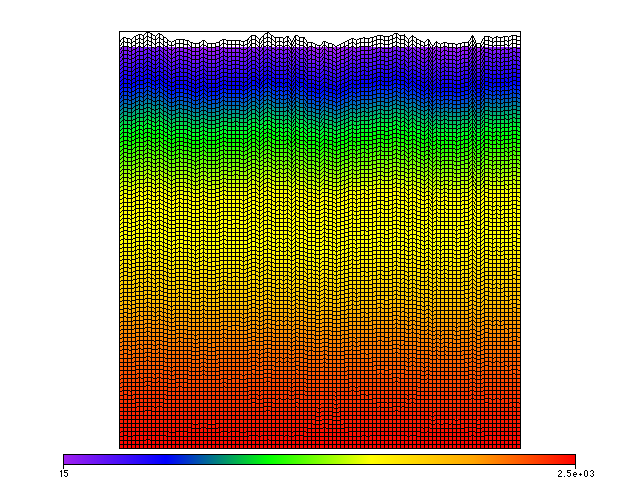

In [50]:
figtemp.show()

In [51]:
temperatureField.data.mean()
#toptemp + deltemp

1566.9703787888636

In [52]:
u

0.5

In [53]:
step = 0

In [81]:
dt = 0.001 #thousand years
t0 = temperatureField.copy()
t1 = temperatureField.copy()
tol = 1.
tolcheck = []
realtime = 0.

#while tol > 1e-1:
while step < 1500:
    t0.data[:] = np.copy(temperatureField.data[:])
    #dt = advDiff.get_max_dt()
    advDiff.integrate(dt)
    t1.data[:] = np.copy(temperatureField.data[:])
    intField = t1 - t0
    tempint = uw.utils.Integral(intField, velocityMesh)
    tol = tempint.integrate()
    tolcheck.append(tol)
    realtime += dt
    step += 1
    if step % 50 == 0:
        print step, (tol)[0]
        

1050 -3.40675897295
1100 -3.28191382841
1150 -3.1650670418
1200 -3.05542828148
1250 -2.95231426034
1300 -2.85513045659
1350 -2.76335654609
1400 -2.67653468448
1450 -2.59425999989
1500 -2.51617281744


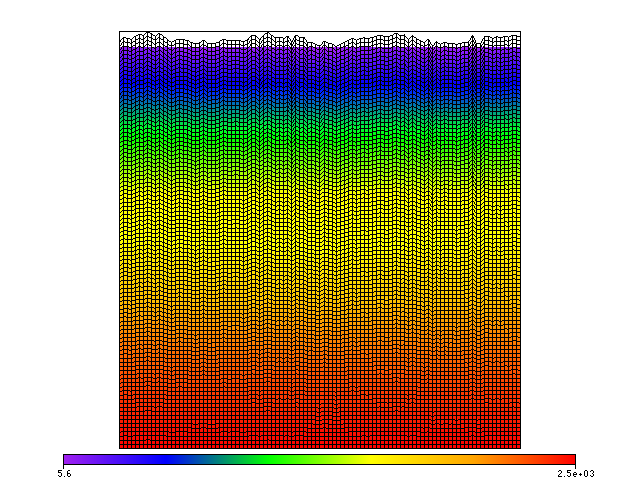

In [82]:
figtemp.show()

#as Numpy array

In [83]:
tempnp = temperatureField.data.reshape(meshY+1, meshX+1,1)
tempnp.shape

(101, 101, 1)

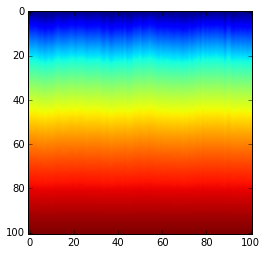

In [84]:
#pyplot.imshow(tempnp[:,:,0])
pyplot.imshow(np.flipud(tempnp[:,:,0]))

In [85]:
depths = np.arange(0,30,5)
depths

array([ 0,  5, 10, 15, 20, 25])

In [86]:
isotherm = temperatureField.evaluate(isoswarm)
isotherm.shape

(101, 1)

In [87]:
depth = 10

notop = T0(depth, TL, TS, L, u, kappa)
analytic = analytic_geotherm(depth, sig_fft, TL, TS, L, u, kappa, DTDY, lapse)
data = np.flipud(tempnp[:,:,0])
numeric = data[depth,:]

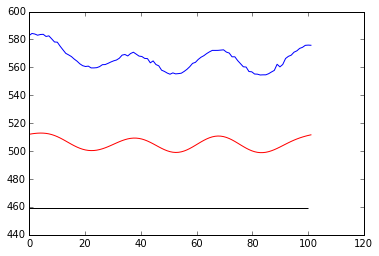

In [88]:
#data = np.flipud(tempnp[:,:,0])
#for i in depths:

pyplot.plot(horizontals, analytic, color= "red")
pyplot.plot(horizontals, isotherm, color= "blue")
pyplot.hlines(notop,0,100 )

In [62]:
#horizontals.shape